## Gaussian decomposable graphical model

Fitting a Gaussian decomposable graphical model to an auto-regressive G. 

In [3]:
SAVE_PLOTS = False
SAVE_LOC =  '/home/mo/src/decomposable_paper/img/'

In [50]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import time
from scipy.interpolate import make_interp_spline
from parallelDG.graph import trajectory
import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.distributions.g_intra_class as gic
import parallelDG.auxiliary_functions as aux
from parallelDG.distributions import discrete_dec_log_linear as loglin, g_inv_wishart
import parallelDG.mh_parallel as pdg
from networkx.drawing.nx_pydot import graphviz_layout
sns.set_style("whitegrid")
options = {
    "font_size": 8,
    "node_size": 100,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}
def save_location(filename, loc = SAVE_LOC):
    if SAVE_PLOTS:
        plt.savefig(loc + filename + '.png', dpi = 600, bbox_inches='tight')
    else: 
        plt.show()
    
def smooth(x, y):
    if not x: 
        x = list(range(len(y)))
    X_Y_Spline = make_interp_spline(x, y, k=3)
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(np.min(x), np.max(x), 500)
    Y_ = X_Y_Spline(X_)
    return X_, Y_

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simulating AR(1-5) Gaussian graphical model

In [7]:
p = 50
sigma2 = 1.0
rho = 0.9
n = 100
delta = 5

Number of edges 85, number of nodes 50
loglikelihood 1592.785678


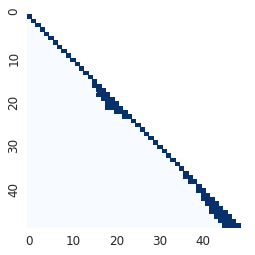

In [52]:
np.random.seed(2) # generates same data as in the paper
ar_graph = dlib.sample_random_AR_graph(n_dim=p, max_bandwidth=delta)
aux.plot_heatmap(nx.to_numpy_array(ar_graph), xticklabels=10, yticklabels=10)
ar_cov_mat = gic.cov_matrix(ar_graph, rho, sigma2)
ar_cov_mat = g_inv_wishart.sample(ar_graph, p+delta, np.matrix(np.identity(p)) )
ar_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(p), ar_cov_mat, n))
print('Number of edges {}, number of nodes {}'.format(ar_graph.size(), ar_graph.order()))
print('loglikelihood {:2f}'.format(pdg.ggm_loglikelihood(dataframe=ar_df,
                                                         graph=ar_graph,
                                                         graph_prior=['uniform'], 
                                                         delta=delta)))
save_location('ggm_true_graph_adj')

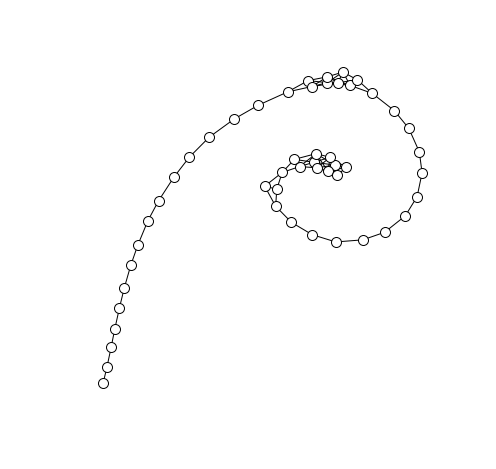

In [53]:
# Graph
plt.figure(figsize=(8,8))
pos = graphviz_layout(ar_graph, prog="fdp",)
nx.draw_networkx(ar_graph,pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
save_location('ggm_true_graph')

# Inference

## Parallel Metropolis-Hasting Junction-domain sampler

In [6]:
n_samples = 500000
randomize  = 100
graph_prior = ['uniform']
delta = 5.0
burnin = 200000
seed = 5

In [7]:
tic = time.time()
traj = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed,
                                parallel=True)
toc = time.time()
print('Time taken {:.2f}sec'.format(toc-tic))

Metropolis-Hastings - parallel moves: 100%|██████████| 499999/499999 [01:14<00:00, 6677.71it/s]

Total of 1237033 updates, for an average of 2.47 per iteration or 16514.92updates/sec
Acceptance rate 0.4876
Time taken 74.91sec


### Graph number of edges

mcmc_index


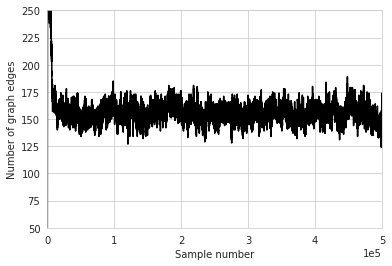

In [8]:
traj._size=None
traj.graph_updates = None
traj.set_graph_trajectories()
traj.size().plot(color = 'black')
size_mcmc_index = list(traj._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ylim((50, 250))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_size_traceplot')

mcmc_subindex


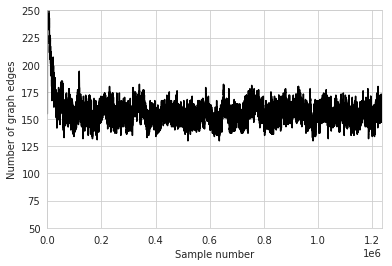

In [9]:
traj._size=None
traj.graph_updates = None
traj.set_graph_trajectories(index_type = 'mcmc_subindex')
traj.size().plot(color = 'black')
size_mcmc_subindex = list(traj._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ylim((50, 250))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

save_location('ggm_size_traceplot_subindex')

### Progressive Acceptance ratio

In [10]:
## by mcmc index and subindex
## of the graph
traj.graph_updates = None
traj.set_graph_trajectories(index_type = 'mcmc_index')
acc_mcmc_index = aux.acceptance_ratio(traj.trajectory)
traj.graph_updates = None
traj.set_graph_trajectories(index_type = 'mcmc_subindex')
acc_mcmc_subindex = aux.acceptance_ratio(traj.trajectory)
## of the juncion tree
up = [0] * (traj.n_updates +1)
for x in traj.jt_updates: `
    up[x[1]] = 1
acc_jt_mcmc_subindex = np.mean(up, dtype=float), np.cumsum(up, dtype=float)/(np.array(range(len(up))) + 1.0)
print('Acceptance ratio  of junction tree updates{:2f}'.format(acc_jt_mcmc_subindex[0]))

mcmc_index
Acceptance ratio 0.078240
mcmc_subindex
Acceptance ratio 0.033036
Acceptance ratio  of junction tree updates0.487582


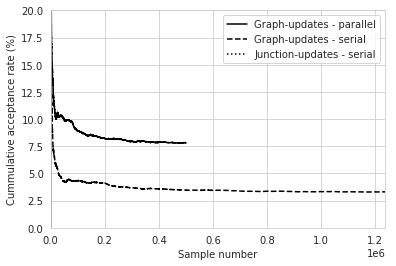

In [11]:
x = list(range(len(acc_mcmc_subindex[1])))
y = acc_mcmc_subindex[1]  * 100
z = acc_mcmc_index[1] * 100
u = acc_jt_mcmc_subindex[1] * 100
plt.plot(list(range(len(z))), z, color='black', label='Graph-updates - parallel')
plt.plot(x, y, color='black', label='Graph-updates - serial', ls='--')
plt.plot(list(range(len(u))), u, color='black', label='Junction-updates - serial', ls = ':')
plt.ylim((0, 20))
plt.xlim((0, max(x)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

### Autocorrelation plot

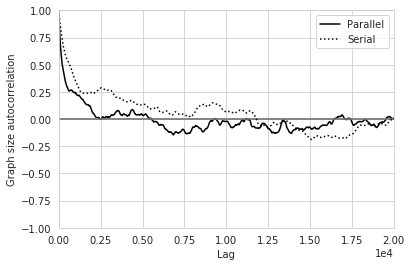

In [12]:
## Auto correlalation plot 
burnin = 50000
lag=20000
df = pd.DataFrame({'mcmc_index': size_mcmc_index[-burnin:],
                   'mcmc_subindex': size_mcmc_subindex[-burnin:]})
aux.autocorrelation_plot(df['mcmc_index'], label = 'Parallel', color = 'black', lag =lag)
aux.autocorrelation_plot(df['mcmc_subindex'], 
                                 label = 'Serial',
                                 color = 'black',
                                    ls = ':', lag = lag)
plt.legend()
plt.ylabel('Graph size autocorrelation')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_autocorrelation')
#plt.show()

### Log-likelihood trace plot

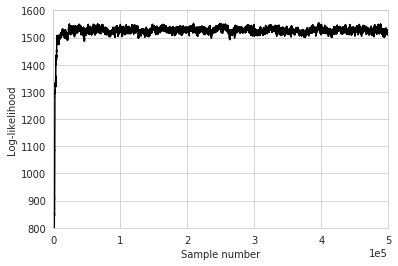

In [13]:
traj.log_likelihood().plot(color='black')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('Log-likelihood')
plt.xlabel('Sample number')
plt.ylim((800, 1600))
save_location('ggm_loglikelihood_traceplot')

### Maximum A Posteriori Graph

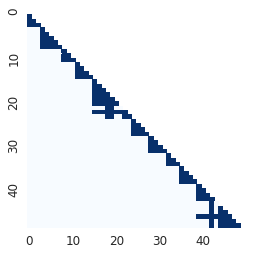

In [14]:
aux.plot_heatmap(nx.to_numpy_array(traj.maximum_likelihood_graph()), xticklabels=10, yticklabels=10)
save_location('ggm_est_map_graph')

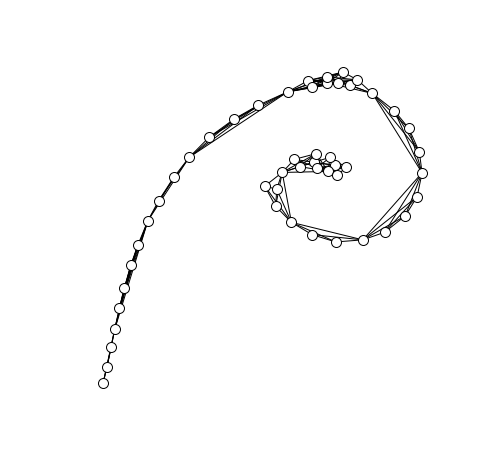

In [15]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(traj.maximum_likelihood_graph(),pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

### Trace plot heatmap

In [16]:
emp=traj.empirical_distribution(burnin).heatmap()

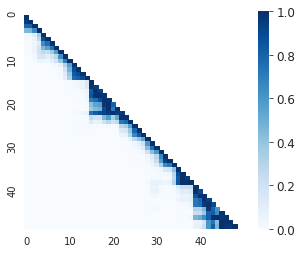

In [17]:
sns.set_style("whitegrid")
aux.plot_heatmap(emp, xticklabels=10, yticklabels=10 ,cbar = True)
save_location('ggm_est_heatmap')

### Most sampled graph

In [18]:
most_sampled = aux.most_sampled_graph(traj.trajectory[burnin:])
most_sampled

{'count': 769.0, 'g': <networkx.classes.graph.Graph at 0x7fae85652990>}

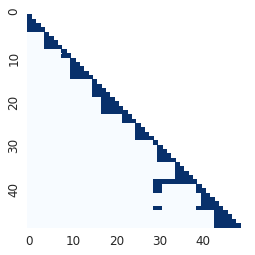

In [19]:
aux.plot_heatmap(nx.to_numpy_array(most_sampled['g']), xticklabels=10, yticklabels=10)
save_location('ggm_est_most_sampled_graph')

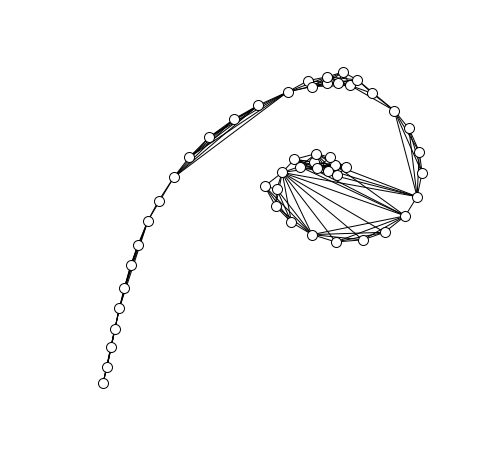

In [20]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(most_sampled['g'],pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()


# Single-partition sampler

In [21]:
n_samples = 1000000
randomize  = 100
graph_prior = ['uniform']
delta = 5.0
burnin = 300000
sns.set_style("whitegrid")
tic = time.time()
seed = 2
traj_single = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed,
                                 parallel = False)
toc = time.time()
print('Time taken {:.2f}sec'.format(toc-tic))

Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:40<00:00, 9931.20it/s] 


Total of 1000000 updates, for an average of 1.00 per iteration or 9928.65updates/sec
Acceptance rate 0.1550
Time taken 100.73sec


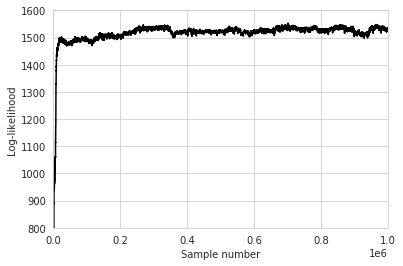

In [22]:
# Loglikelihood  trace plot
traj_single.log_likelihood().plot(color='black')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('Log-likelihood')
plt.xlabel('Sample number')
plt.ylim((800,1600))
save_location('ggm_loglikelihood_traceplot_single_move')

mcmc_index


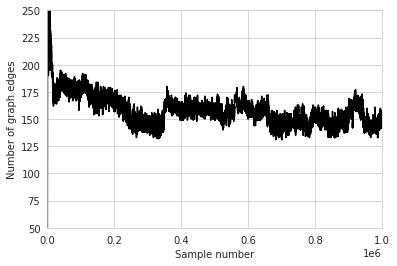

In [23]:
traj_single._size=None
traj_single.graph_updates = None
traj_single.set_graph_trajectories(index_type = 'mcmc_index')
traj_single.size().plot(color = 'black')
single_move_size_mcmc_index = list(traj_single._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ylim((50,250))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_size_traceplot_single_move')            


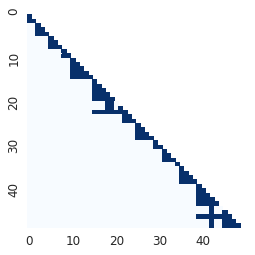

In [24]:
aux.plot_heatmap(nx.to_numpy_array(traj_single.maximum_likelihood_graph()), xticklabels=10, yticklabels=10)
#save_location('ggm_est_map_graph')

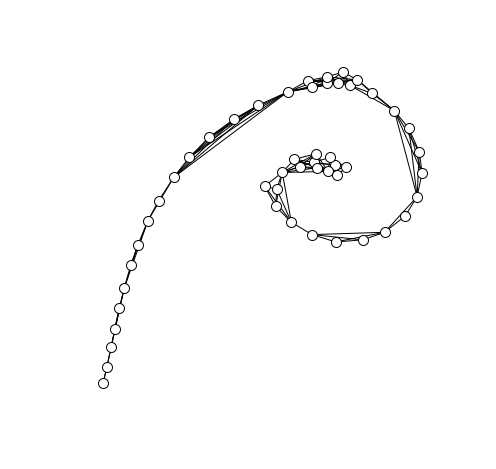

In [25]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(traj_single.maximum_likelihood_graph(),pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [26]:
## by mcmc index and subindex
## of the graph
traj_single.graph_updates = None
traj_single.set_graph_trajectories(index_type = 'mcmc_index')
acc_single_move_mcmc_index = aux.acceptance_ratio(traj_single.trajectory)

mcmc_index
Acceptance ratio 0.018349


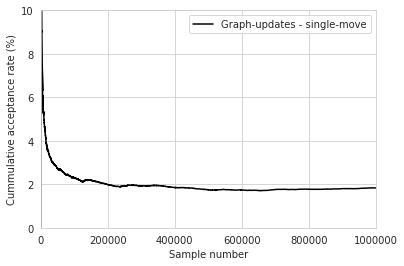

In [27]:
## plottting acceptance ratio
f = acc_single_move_mcmc_index[1] * 100
plt.plot(list(range(len(f))), f, color='black', label='Graph-updates - single-move')
plt.ylim((0, 10))
plt.xlim((0, len(f)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
save_location('ggm_acceptance_ratio_single_move')

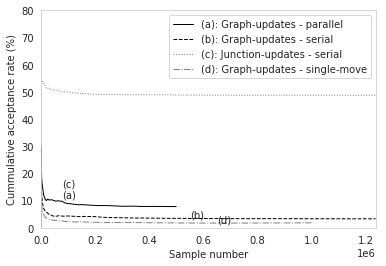

In [28]:
## Plotting joint acceptance ratio
x, y = smooth(x = None,y = acc_mcmc_subindex[1]  * 100)
xz, z = smooth(None,acc_mcmc_index[1] * 100 )
xu, u = smooth(None, acc_jt_mcmc_subindex[1] * 100)
xff, ff = smooth(None, f)

#x = list(range(len(acc_mcmc_subindex[1])))
#y = acc_mcmc_subindex[1]  * 100
#z = acc_mcmc_index[1] * 100
#u = acc_jt_mcmc_subindex[1] * 100
lw = 1
ax = plt.plot(xz, z, color='black', label='(a): Graph-updates - parallel',lw = lw)
plt.plot(x, y, color='black', label='(b): Graph-updates - serial', ls='--', lw = lw)
plt.plot(xu, u, color='grey', label='(c): Junction-updates - serial', ls = ':', lw=lw)
plt.plot(xff, ff, color='grey',label='(d): Graph-updates - single-move', ls = '-.', lw=lw)
plt.ylim((0, 80))
plt.xlim((0, max(x)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.annotate('(d)', xy=(650000,2))
plt.annotate('(b)', xy=(550000,3.6))
plt.annotate('(a)', xy=(80000,11))
plt.annotate('(c)', xy=(80000,15))
plt.grid(False)
save_location('ggm_acceptance_ratio_all')

### Autocorrelation plot

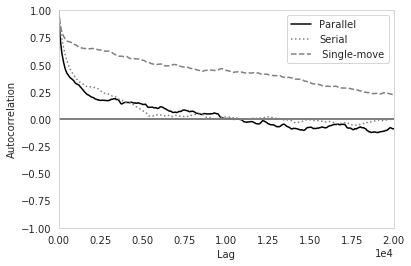

In [29]:
## Auto correlalation plot 
lag = 20000
df = pd.DataFrame({'mcmc_index': size_mcmc_index[-burnin:],
                   'mcmc_subindex': size_mcmc_subindex[-burnin:],
                    'mcmc_index_single_move': single_move_size_mcmc_index[-burnin:]})
aux.autocorrelation_plot(df['mcmc_index'], label = 'Parallel', color = 'black', lag = lag)
aux.autocorrelation_plot(df['mcmc_subindex'], 
                                 label = 'Serial',
                                 color = 'grey',
                                    ls = ':', lag = lag)
aux.autocorrelation_plot(df['mcmc_index_single_move'], 
                                 label = ' Single-move',
                                 color = 'grey',
                                    ls = '--', lag = lag)
plt.legend()
plt.ylabel('Autocorrelation')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_autocorrelation')

In [30]:
acc_ratios_single = traj_single.dummy
total = [np.sum(x) for x in acc_ratios_single]
proposal = [x[2] for x in acc_ratios_single]
dt_single = pd.DataFrame({'total': total, 'proposal':proposal})
dt_single['likelihood'] = dt_single['total'] - dt_single['proposal']
dt_single['proposal_exp'] = np.exp(dt_single['proposal'])
dt_single['total_exp'] = np.exp(dt_single['total'])
dt_single['likelihood_exp'] = np.exp(dt_single['likelihood'])


# Prior sensitivity

In [56]:
n_samples = 100000
randomize  = 100
graph_prior = ['uniform']
delta = 5.0
burnin = 200000
seed = 0

In [57]:
tic = time.time()
traj = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed, 
                                parallel=False)
toc = time.time()
print('Time taken {:.2f}sec'.format(toc-tic))

Metropolis-Hastings - single-move: 100%|██████████| 99999/99999 [00:57<00:00, 1729.91it/s]


Total of 100000 updates, for an average of 1.00 per iteration or 1729.56updates/sec
Acceptance rate 0.4736
Time taken 58.01sec


In [58]:
## by mcmc index and subindex
## of the graph
traj.graph_updates = None
traj.set_graph_trajectories(index_type = 'mcmc_index')
acc_mcmc_index = aux.acceptance_ratio(traj.trajectory)
traj.graph_updates = None
## of the juncion tree
up = [0] * (traj.n_updates+1) 
for x in traj.jt_updates: 
    up[x[1]] = 1
acc_jt_mcmc_subindex = np.mean(up, dtype=float), np.cumsum(up, dtype=float)/(np.array(range(len(up))) + 1.0)
print('Acceptance ratio  of junction tree updates{:2f}'.format(acc_jt_mcmc_subindex[0]))

mcmc_index
Acceptance ratio 0.273203
Acceptance ratio  of junction tree updates0.473545


In [59]:
tic = time.time()
traj_tight_prior = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = ['mbc', 2.0, 4.0],
                                 delta = delta, 
                                 seed = seed, 
                                 parallel=False)
toc = time.time()
print('Time taken {:.2f}sec'.format(toc-tic))

Metropolis-Hastings - single-move: 100%|██████████| 99999/99999 [00:55<00:00, 1813.91it/s]

Total of 100000 updates, for an average of 1.00 per iteration or 1813.60updates/sec
Acceptance rate 0.1925
Time taken 55.21sec


In [60]:
## by mcmc index and subindex
## of the graph
traj_tight_prior.graph_updates = None
traj_tight_prior.set_graph_trajectories(index_type = 'mcmc_index')
acc_mcmc_index_prior = aux.acceptance_ratio(traj_tight_prior.trajectory)
## of the juncion tree
up = [0] * (traj_tight_prior.n_updates+1)
for x in traj_tight_prior.jt_updates: 
    up[x[1]] = 1
acc_jt_mcmc_subindex_prior = np.mean(up, dtype=float), np.cumsum(up, dtype=float)/(np.array(range(len(up))) + 1.0)
print('Acceptance ratio  of junction tree updates{:2f}'.format(acc_jt_mcmc_subindex_prior[0]))

mcmc_index
Acceptance ratio 0.106351
Acceptance ratio  of junction tree updates0.192518


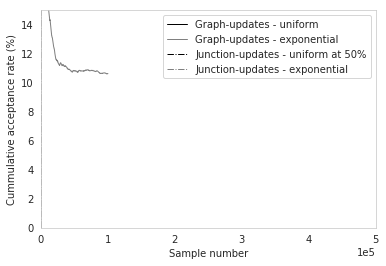

In [61]:
## Plotting joint acceptance ratio
x, y = smooth(None, acc_mcmc_index[1]  * 100)
xt, t = smooth(None, acc_jt_mcmc_subindex[1] * 100)
xz, z = smooth(None, acc_mcmc_index_prior[1] * 100)
xi, i = smooth(None, acc_jt_mcmc_subindex_prior[1] * 100)

lw = 1
ax = plt.plot(x, y, color='black', label='Graph-updates - uniform',lw = lw)
plt.plot(xz, z, color='grey',label='Graph-updates - exponential', lw=lw)
plt.plot(xt, t, color='black', label='Junction-updates - uniform at 50%', ls='-.', lw = lw)
plt.plot(xi, i, color='grey', label='Junction-updates - exponential', ls = '-.',lw=lw)
plt.ylim((0, 15))
plt.xlim((0, 5e5))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid(False)
save_location('ggm_acceptance_uniform_mbc')

In [65]:
import pandas as pd

avg_y_uniform = round(np.mean(y), 2)
avg_z_exponential = round(np.mean(z), 2)
avg_t_uniform = round(np.mean(t), 2)
avg_i_exponential = round(np.mean(i), 2)

# Organize the data into a 4x4 table
data = {
    '': ['Uniform prior', 'Exponential prior'],
    'Graph-updates': [avg_y_uniform, avg_z_exponential],
    'Junction-updates': [avg_t_uniform, avg_i_exponential]
}

# Create a DataFrame
df = pd.DataFrame(data)
df



,,Graph-updates,Junction-updates
0,Uniform prior,28.17,48.05
1,Exponential prior,12.38,22.52


In [66]:

# Export to LaTeX
latex_code = df.to_latex(index=False)
print(latex_code)

\begin{tabular}{lrr}
\toprule
                   &  Graph-updates &  Junction-updates \\
\midrule
     Uniform prior &          28.17 &             48.05 \\
 Exponential prior &          12.38 &             22.52 \\
\bottomrule
\end{tabular}

